In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from afinn import Afinn

from collections import Counter

nltk.download('opinion_lexicon')




[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/ewelinanowak/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [9]:
friends_df = pd.read_csv('friends.csv')
friends_info_df = pd.read_csv('friends_info.csv')
friends_emotions_df = pd.read_csv('friends_emotions.csv')

## Data info 

In [10]:
friends_df.head()

,text,speaker,season,episode,scene,utterance
0,There's nothing to tell! He's just some guy I ...,Monica Geller,1,1,1,1
1,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,1,1,1,2
2,"All right Joey, be nice. So does he have a hum...",Chandler Bing,1,1,1,3
3,"Wait, does he eat chalk?",Phoebe Buffay,1,1,1,4
4,"(They all stare, bemused.)",Scene Directions,1,1,1,5


In [11]:
friends_info_df.head()

,season,episode,title,directed_by,written_by,air_date,us_views_millions,imdb_rating
0,1,1,The Pilot,James Burrows,David Crane & Marta Kauffman,1994-09-22,21.5,8.3
1,1,2,The One with the Sonogram at the End,James Burrows,David Crane & Marta Kauffman,1994-09-29,20.2,8.1
2,1,3,The One with the Thumb,James Burrows,Jeffrey Astrof & Mike Sikowitz,1994-10-06,19.5,8.2
3,1,4,The One with George Stephanopoulos,James Burrows,Alexa Junge,1994-10-13,19.7,8.1
4,1,5,The One with the East German Laundry Detergent,Pamela Fryman,Jeff Greenstein & Jeff Strauss,1994-10-20,18.6,8.5


In [12]:
friends_emotions_df.head()

,season,episode,scene,utterance,emotion
0,1,1,4,1,Mad
1,1,1,4,3,Neutral
2,1,1,4,4,Joyful
3,1,1,4,5,Neutral
4,1,1,4,6,Neutral


## Characters - data cleaning

In [13]:
friends_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67373 entries, 0 to 67372
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       67373 non-null  object
 1   speaker    67097 non-null  object
 2   season     67373 non-null  int64 
 3   episode    67373 non-null  int64 
 4   scene      67373 non-null  int64 
 5   utterance  67373 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 3.1+ MB


276 null values in speaker column - remove them 

In [14]:
friends_df.dropna(inplace=True)

In [15]:
friends_df['speaker'].value_counts()[:10]

speaker
Rachel Green        9312
Ross Geller         9157
Chandler Bing       8465
Monica Geller       8441
Joey Tribbiani      8171
Phoebe Buffay       7501
Scene Directions    6063
#ALL#                347
Mike Hannigan        330
Richard Burke        281
Name: count, dtype: int64

'Scene Directions' - unnecessary, let's remove them.

In [16]:
friends_df.drop(friends_df[friends_df['speaker'] == 'Scene Directions'].index, inplace=True)

Who speaks the most often?

<Axes: xlabel='speaker'>

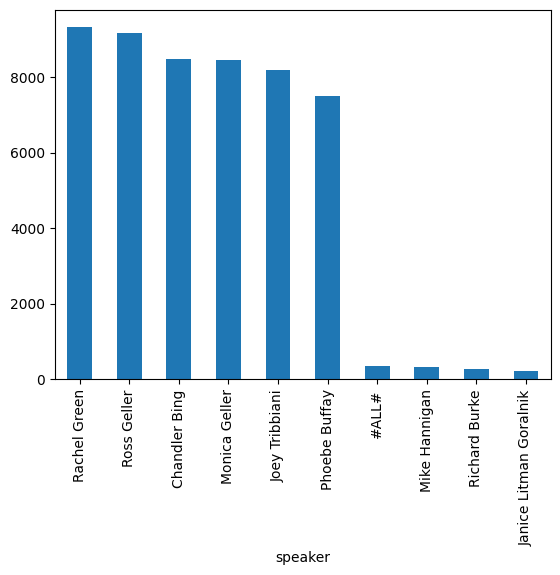

In [17]:
friends_df['speaker'].value_counts()[:10].plot(kind='bar')

Ok, let's focus on 6 main characters. 

In [18]:
speakers = friends_df['speaker'].value_counts()[:6]

In [19]:
main_texts_df = pd.merge(friends_df, speakers, right_index=True, left_on='speaker')

In [20]:
main_texts_df.head()

,text,speaker,season,episode,scene,utterance,count
0,There's nothing to tell! He's just some guy I ...,Monica Geller,1,1,1,1,8441
1,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,1,1,1,2,8171
2,"All right Joey, be nice. So does he have a hum...",Chandler Bing,1,1,1,3,8465
3,"Wait, does he eat chalk?",Phoebe Buffay,1,1,1,4,7501
5,"Just, 'cause, I don't want her to go through w...",Phoebe Buffay,1,1,1,6,7501


In [21]:
speaker_by_season = main_texts_df.groupby(['speaker', 'season']).size().reset_index()

# Character's utterances

In [22]:
def count_utterances_by_season(speaker):
    utterances_by_season = speaker_by_season[speaker_by_season['speaker'] == f'{speaker}']
    utterances_by_season = utterances_by_season.rename(columns={0:'count'})

    fig, ax = plt.subplots()

    seasons = utterances_by_season['season']
    utterances_count = utterances_by_season['count']
    bars = ax.bar(range(len(utterances_by_season['season'])), utterances_by_season['count'])
    ax.set_title(f"{speaker}'s utterances")
    ax.set_xlabel('Season')
    ax.set_ylabel('Number of utterances')

    plt.xticks(ticks=range(len(utterances_by_season['season'])), labels=utterances_by_season['season'])

    # labels
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')

    # max value
    max_value = max(utterances_count)

    for bar in bars:
        if bar.get_height() == max_value:
            bar.set_color('green')


    # min value
    min_value = min(utterances_count)

    for bar in bars:
        if bar.get_height() == min_value:
            bar.set_color('red')
    

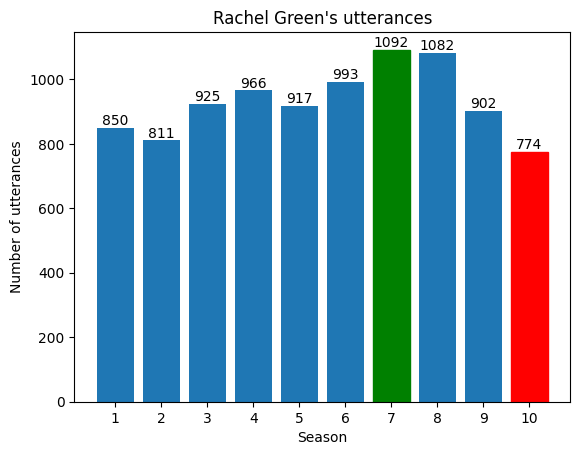

In [23]:
count_utterances_by_season("Rachel Green")

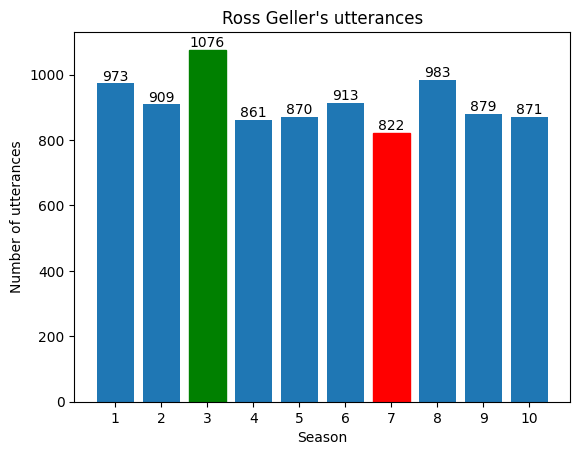

In [24]:
count_utterances_by_season("Ross Geller")

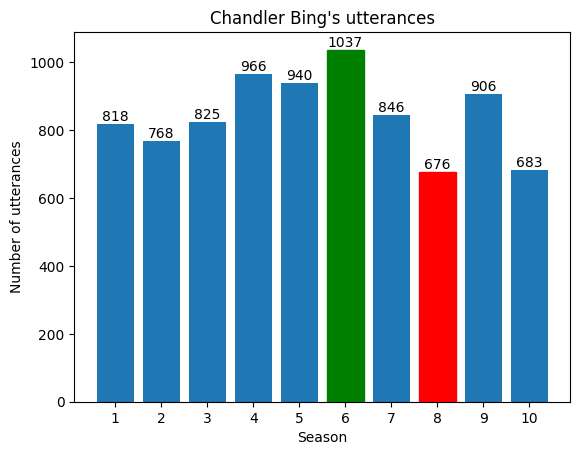

In [25]:
count_utterances_by_season("Chandler Bing")

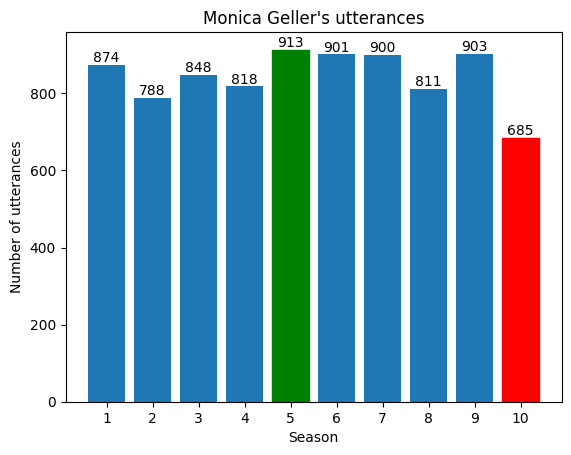

In [26]:
count_utterances_by_season("Monica Geller")

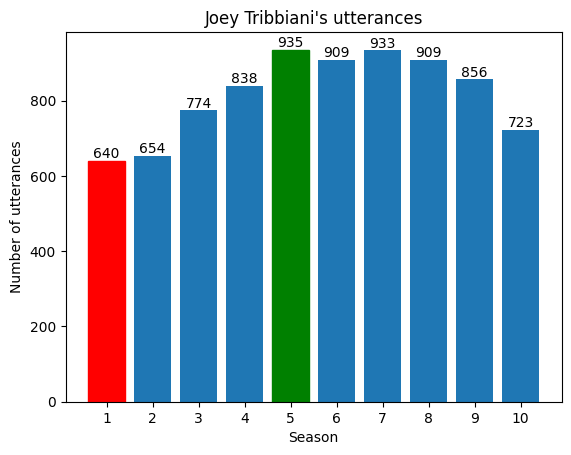

In [27]:
count_utterances_by_season("Joey Tribbiani")

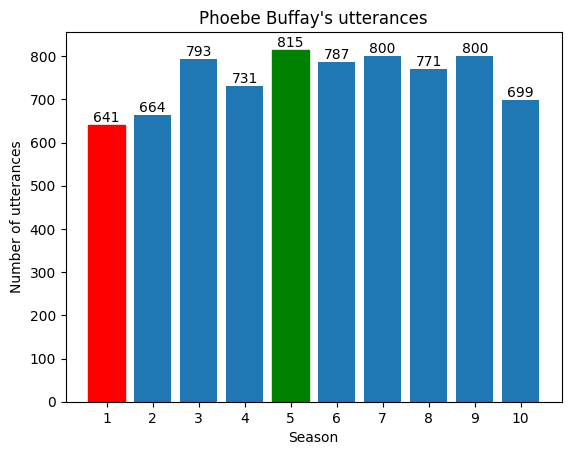

In [28]:
count_utterances_by_season("Phoebe Buffay")

In [29]:
texts_pivot = main_texts_df.pivot_table(values='count', index='season', columns='speaker', aggfunc='size')

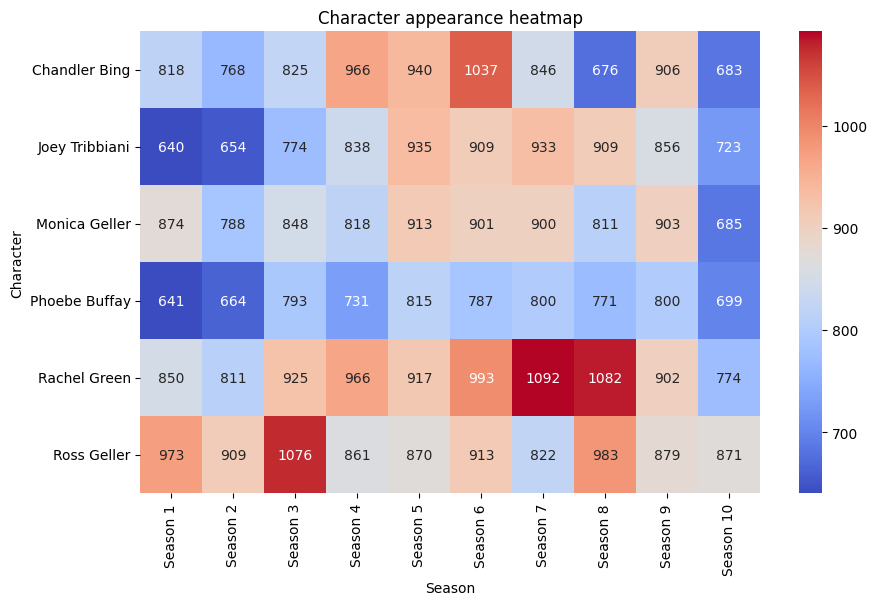

In [30]:
# Dane do heatmapy
data = {
    'Season 1': list(texts_pivot.loc[1]),
    'Season 2': list(texts_pivot.loc[2]),
    'Season 3': list(texts_pivot.loc[3]),
    'Season 4': list(texts_pivot.loc[4]),
    'Season 5': list(texts_pivot.loc[5]),
    'Season 6': list(texts_pivot.loc[6]),
    'Season 7': list(texts_pivot.loc[7]),
    'Season 8': list(texts_pivot.loc[8]),
    'Season 9': list(texts_pivot.loc[9]),
    'Season 10': list(texts_pivot.loc[10])
}
characters = texts_pivot.columns

df = pd.DataFrame(data, index=characters)

plt.figure(figsize=(10, 6))  
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='d')  # annot=True adds numerical annotations to each cell
plt.title('Character appearance heatmap')
plt.xlabel('Season')
plt.ylabel('Character')
plt.show()

### Changes in appearances of the characters:

- high frequency of Chandler's appearance in seasons 4-6: 
    * romantic relationship with Monica
    * career changes

- significant increase in Joey's parts in seasons 5-8:
    * landing Dr. Drake Ramoray role
    * relationship with Kathy (Chandler's ex-girfriend)
    * feelings for Rachel
    * fired from Days of Our Lives

- Monica's increase in seasons 5-7:
    * relationship with Chandler 
    * getting married 

- Phoebe doesn't say much throughout the whole series

- Rachel, seasons 7-8:
    * landing a job at Ralph Lauren
    * romance with Joey
    * getting pregnant 

- Ross, frequent in season 3:
    * We were on a break!
    * Ross's jealousy towards Rachel
    * co-parenting 


In season 10 the characters don't say much to emphasize the weight of the impending conclusion and allow for more poignant moments of reflection and expression through non-verbal communication.

In [31]:
speaker_by_season = speaker_by_season.rename(columns={0: 'count'})

In [32]:
speaker_by_season['category'] = pd.cut(speaker_by_season['count'], bins=[0, speaker_by_season['count'].quantile(.5), float('inf')], labels=['supporting', 'main'])

In [33]:
texts_pivot = main_texts_df.pivot_table(values='count', index='season', columns='speaker', aggfunc='size')

In [34]:
texts_cat_pivot = pd.pivot_table(speaker_by_season, values='category', index='season', columns='speaker', aggfunc='first')

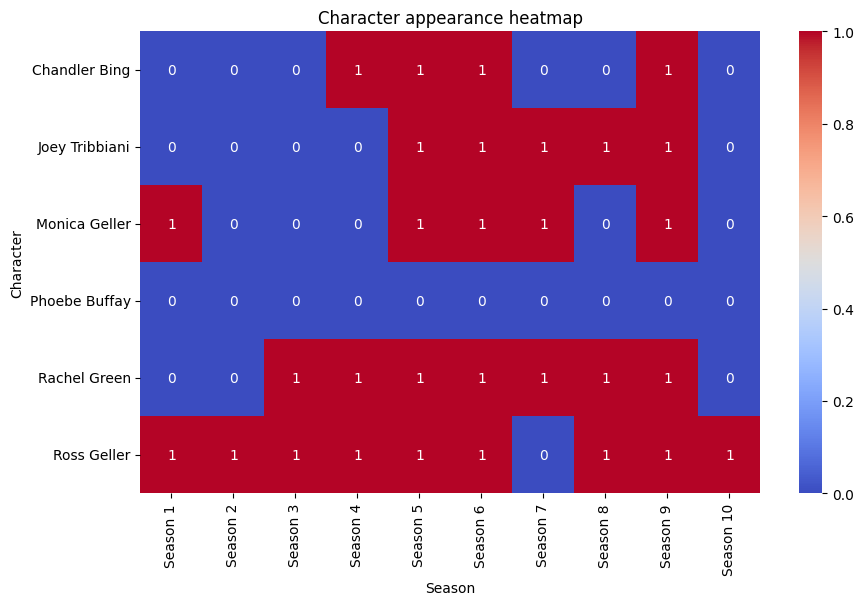

In [35]:
data = {
    'Season 1': list(texts_cat_pivot.loc[1]),
    'Season 2': list(texts_cat_pivot.loc[2]),
    'Season 3': list(texts_cat_pivot.loc[3]),
    'Season 4': list(texts_cat_pivot.loc[4]),
    'Season 5': list(texts_cat_pivot.loc[5]),
    'Season 6': list(texts_cat_pivot.loc[6]),
    'Season 7': list(texts_cat_pivot.loc[7]),
    'Season 8': list(texts_cat_pivot.loc[8]),
    'Season 9': list(texts_cat_pivot.loc[9]),
    'Season 10': list(texts_cat_pivot.loc[10])
}
characters = texts_cat_pivot.columns

for season in data.keys():
    data[season] = [1 if val == 'main' else 0 for val in data[season]]


df = pd.DataFrame(data, index=characters)

plt.figure(figsize=(10, 6))  
sns.heatmap(df, annot=True, cmap='coolwarm')  # annot=True adds numerical annotations to each cell
plt.title('Character appearance heatmap')
plt.xlabel('Season')
plt.ylabel('Character')
plt.show()

1. Ross and Rachel are the most 'talkative' couple of the series.
2. In season 5 Joey, Chandler and Monica start to appear more frequently.
3. Phoebe doesn't say much throughout the series. 


# Character frequency, season rating & views

Let's see the seasons' rating and views

In [36]:
rating_views = friends_info_df.groupby('season')[['imdb_rating', 'us_views_millions']].mean().round(2)
rating_views = rating_views.rename(columns={'imdb_rating': 'rating', 'us_views_millions': 'views'})

<Axes: >

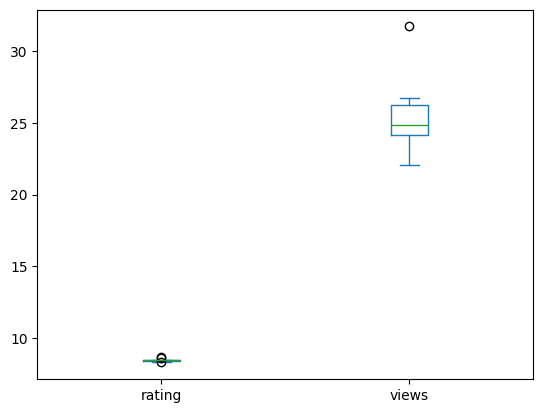

In [37]:
rating_views.plot(kind='box')

In [38]:
rating_views.describe()

,rating,views
count,10.000000,10.000000
mean,8.469000,25.397000
std,0.122334,2.690614
min,8.300000,22.050000
25%,8.417500,24.135000
50%,8.455000,24.870000
75%,8.495000,26.265000
max,8.690000,31.720000


There is an outlier:
- season 2 has 31.72 mln views
- while mean views is 25.39
- which in season 2 is over 2 * std (2.49)

It's quite surprising considering the fact that it's the season where none of the characters (besides Ross) talk much. We can then assume that the most popular is non-verbal type of humor. 

In season 2 there were also a few supporting characters (Richard, Julie, Ursula, Janice), which can be the reson why the main focus wasn't placed on the 6 main characters. We can also guess that people enjoy the supporting characters and it generates a lot of views. 

Season 2 has the average rating. 

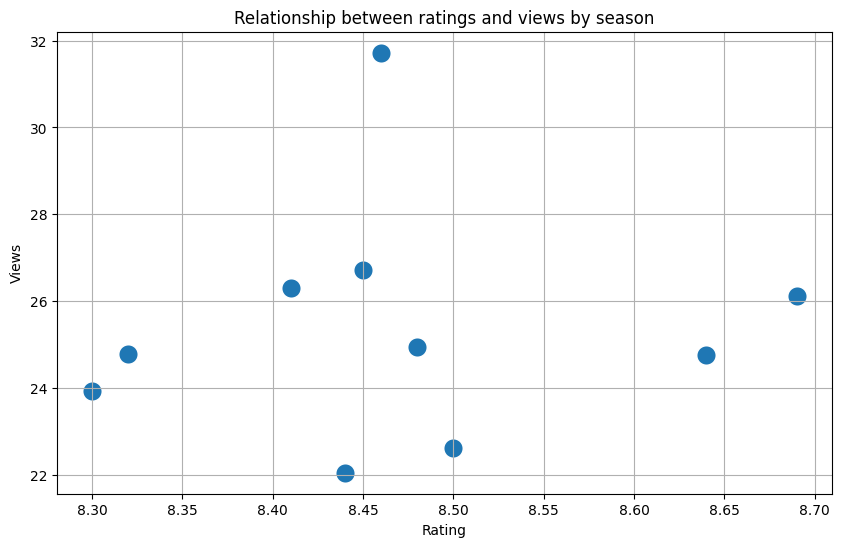

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='views', data=rating_views, s=200)

plt.title('Relationship between ratings and views by season')
plt.xlabel('Rating')
plt.ylabel('Views')

plt.grid(True)
plt.show()

It seems that there isn't any corelation between rating and views. But let's check another plot.

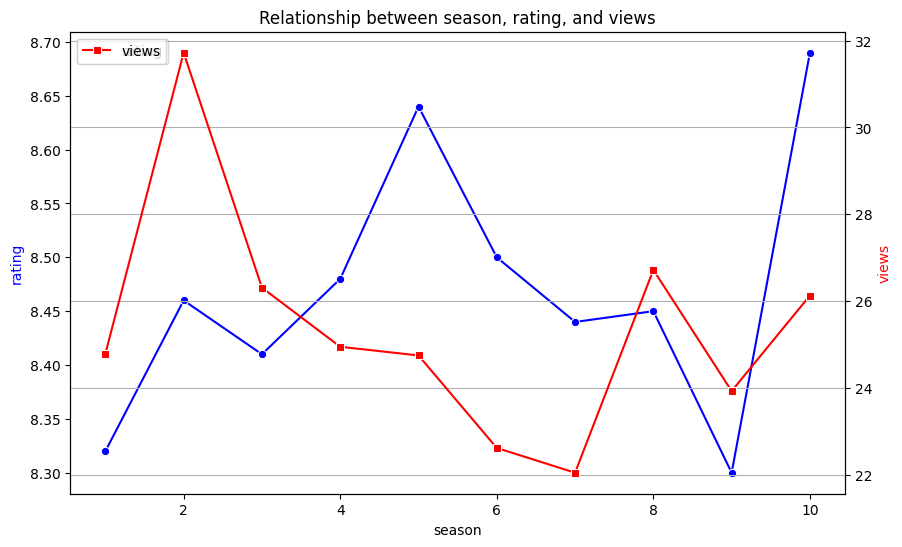

In [40]:
plt.figure(figsize=(10, 6))

# rating
sns.lineplot(x='season', y='rating', data=rating_views, marker='o', color='b', label='rating')

# rating label
plt.ylabel('rating', color='b')

# views, another axis
ax2 = plt.gca().twinx()
sns.lineplot(x='season', y='views', data=rating_views, marker='s', color='r', label='views', ax=ax2)

# views label
plt.ylabel('views', color='r')

# title
plt.title('Relationship between season, rating, and views')

# legend
plt.legend(loc='upper left')

# display the plot
plt.grid(True)
plt.show()

Season 10 has the highest score. 

Besides season 10, seasons 4-6 have the highest score. 
Rating more or less correspond to number of views, BUT when the rating of season 5 reaches a peak, the views are dropping. From season 5 to season 6 the views suddenly drop and in season 7 reach the lowest point. 

Why?

- in season 5 (rating's peak, average views):
    * Ross and Emily fail to get married, Ross again reveals his feelings towards Rachel
    * Chandler and Monica have an affair 
    * no significant change in the numnber of character's appearance

After those events people may get tired, bored and irritated with Ross-Rachel relationship hence the drop in views. /personal opinion: in season 5 and 6 Rachel is quite annoying with her jealousy/

There are some other potential reasons:

- concept fatigue: after several years on air, viewers might have experienced concept fatigue with the series
- competition: season 6 might have competed with other popular TV programs airing at the same time ("Malcolm in the Middle", "Scrubs")

- seasons 6 and 7:
    * bored with Ross-Rachel 
    * heatmaps shows that Rachel is the most talkative person in season 7 (she can be annoying)
    
BUT

- in season 7 there is Mike, who turns out to be a lovable character and adds some freshness to the series. That may be the reason why the views recovered after season 7. 



# Most frequently used words

#### I'm going to use nltk library to create tokens and clean the data 

In [41]:
words = " ".join(main_texts_df['text'])

In [42]:
import nltk
nltk.data.path.insert(0, '/Users/ewelinanowak/nltk_data')

In [44]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ewelinanowak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ewelinanowak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
tokens = word_tokenize(words)

In [95]:
tokens_cleaned = [word.lower() for word in tokens if word.isalpha()]
tokens_cleaned = [word for word in tokens_cleaned if word not in list(stopwords.words('english'))]

In [96]:
tokens_dict = {
    token: tokens_cleaned.count(token) for token in set(tokens_cleaned)
}

In [74]:
words_df = pd.DataFrame({
    'word': list(tokens_dict.keys()), 'count': list(tokens_dict.values())
}).sort_values(by='count', ascending=False)

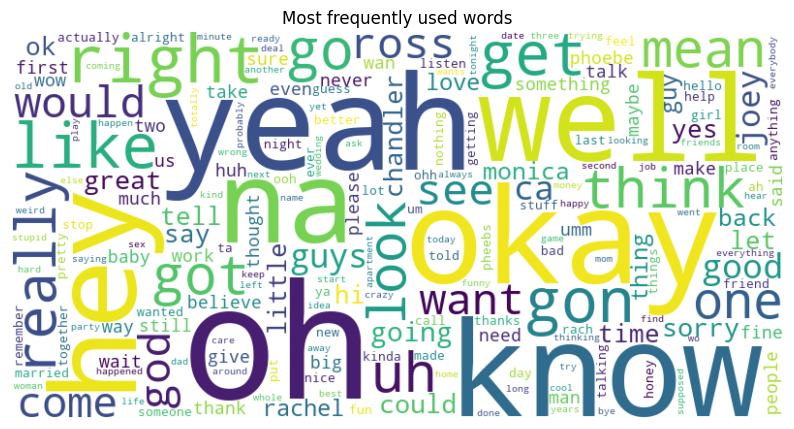

In [114]:
top_words = words_df.head(10)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tokens_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequently used words')
plt.show()

In [142]:
friends_df['text'] = friends_df['text'].str.lower()
main_texts_df['text'] = main_texts_df['text'].str.lower()

In [143]:
word_know = main_texts_df[main_texts_df['text'].str.contains('know')]

In [144]:
word_know.groupby('speaker').size().sort_values(ascending=False).head(20)

speaker
Rachel Green      1120
Ross Geller        951
Phoebe Buffay      927
Chandler Bing      859
Joey Tribbiani     843
Monica Geller      740
dtype: int64

In [171]:
text_by_speaker = main_texts_df.groupby('speaker')['text'].agg(lambda x: ' '.join(x)).reset_index()

In [231]:
def frequent_words(speaker):
    text_speaker = text_by_speaker.loc[text_by_speaker['speaker'] == f'{speaker}', 'text']
    words_speaker = word_tokenize(list(text_speaker)[0])
    words_speaker = [word for word in words_speaker if word.isalpha() and word not in list(stopwords.words('english'))]

    counter = Counter(words_speaker)
    words_speaker_df = pd.DataFrame(list(counter.items()), columns=['word', 'count']).sort_values(by='count', ascending=False)

    return words_speaker_df

In [243]:
words_monica_df = frequent_words('Monica Geller')
words_phoebe_df = frequent_words('Phoebe Buffay')
words_ross_df = frequent_words('Ross Geller')
words_rachel_df = frequent_words('Rachel Green')
words_joey_df = frequent_words('Joey Tribbiani')
words_chandler_df = frequent_words('Chandler Bing')

# Sentiment

In [292]:
def show_sentiment(speaker):
    afinn = Afinn()

    text = text_by_speaker.loc[text_by_speaker['speaker'] == f'{speaker}', 'text'].iloc[0]

    sentiment_score = afinn.score(text)

    return sentiment_score

In [302]:
pd.DataFrame({
    'name': ['Rachel Green',
            'Ross Geller',
            'Chandler Bing',
            'Monica Geller',
            'Joey Tribbiani',
            'Phoebe Buffay'],
    'sentiment': [show_sentiment('Rachel Green'),
                    show_sentiment('Ross Geller'),
                    show_sentiment('Chandler Bing'),
                    show_sentiment('Monica Geller'),
                    show_sentiment('Joey Tribbiani'),
                    show_sentiment('Phoebe Buffay')]
}).sort_values(by='sentiment')

,name,sentiment
2,Chandler Bing,3583.0
3,Monica Geller,3974.0
5,Phoebe Buffay,4186.0
4,Joey Tribbiani,4461.0
1,Ross Geller,4722.0
0,Rachel Green,5286.0


Sentiment analysis of all the texts shows that the most 'negative' character is Chandler, which makes perfect sense as he's the most sarcastic and blunt character. The next is Monica, who is also very direct, which may be perceived negative. 

While Chandler and Monica are the most negative couple, Ross and Rachel are the most positive, with Rachel having the highest score of sentiment. She likes to flirt, which may result in complimenting men thus increasing her score. 